# Exploring Github Data

Hello CloudAppDevelopers Community!

In this notebook, we would learn how to use Pyspark + Jupyter Notebook + Qbeast Format to analyze repositories on Github. For this demo we used the Github Archive Dataset, which can be found on https://www.gharchive.org

We upload part of the dataset on a public S3 bucket, so you can try without having to build an scrapping bash script ;)



## Connecting to Spark

The first thing we need to do is to connect this Notebook with the Spark on the Kubernetes Deployment. To do so, add the corresponding configuration to the `SparkSession.builder`. 

For using **Qbeast Format** in Spark, just add the packages to the `spark.sql.package` config.
Since it's based on Delta Lake, we would need their `delta-core` package too.

In [1]:
import os
import time
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer
from pyspark.sql.functions import udf, col, mean, count
from pyspark.sql.types import FloatType, IntegerType

In [2]:

hadoop_deps = ','.join(map(lambda a: 'org.apache.hadoop:hadoop-' + a + ':3.2.0', ['common','client','aws']))
deps = "io.qbeast:qbeast-spark_2.12:0.3.0-alpha-SNAPSHOT,io.delta:delta-core_2.12:2.1.0,com.amazonaws:aws-java-sdk:1.12.20," + hadoop_deps

spark = (SparkSession.builder
         .master("local[*]")
         .config("spark.jars.repositories", "https://s01.oss.sonatype.org/content/repositories/snapshots")
         .config("spark.jars.packages", deps)
         .config("spark.sql.extensions", "io.qbeast.spark.internal.QbeastSparkSessionExtension")
         .config("spark.sql.catalog.spark_catalog", "io.qbeast.spark.internal.sources.catalog.QbeastCatalog")
         .config("spark.hadoop.fs.s3a.aws.credentials.provider", "org.apache.hadoop.fs.s3a.AnonymousAWSCredentialsProvider")
         .getOrCreate())

## Download Data

You can download Github data from the Github Archive Dataset: https://www.gharchive.org 

In [ ]:
#!wget https://data.gharchive.org/2021-10-{01..31}-{0..23}.json.gz

## Pre-processing data

In [4]:
json_raw_data_path = "s3a://qbeast-public-datasets-us/github-archive/all/2021/json/"
qbeast_data_path = "s3a://qbeast-public-datasets-us/github-archive/qbeast/all/2021/10"

In [ ]:
print(f'> > > Reading PARQUET data from {json_raw_data_path}...')
df = spark.read.format("json").load(json_raw_data_path)

# Pre-process the data (clean and prepare to index)
processed_df = (df.withColumn("repo_id", col("repo.id"))
                  .withColumn("event_id", col("id"))
                  .withColumn("event_type", col("type")))

print(f'> > > Saving bronze data in Parquet files...')

# Simulate ingestion process: write in an S3 in Qbeast
processed_df.show()

print(f'> > > Done!')

## Create Raw Table

In [5]:
# Create Table with Spark
spark.read.format("json").load(json_raw_data_path).createOrReplaceTempView("events_bronze")

## Writing with Qbeast

In [ ]:
cols_to_index = ['event_id', 'event_type', 'repo_id']
option_cols_to_index = ",".join(cols_to_index)
source_table = "events_bronze"
table_name = "events"

In [ ]:
print(f">>> Indexing data from {source_table} as {table_name}")

# Save the data as Table to use it through SQL
spark.sql("""
CREATE TABLE events 
USING 
    qbeast
LOCATION 's3a://qbeast-public-datasets-us/github-archive/qbeast/all/2021/10'
OPTIONS 
    ('columnsToIndex'='event_id,event_type,repo_id','cubeSize'='500000')
AS 
SELECT * 
FROM 
    events_bronze""")

print("> > > Done!")

## Create Silver Table

In [6]:
# Create Table with Spark
spark.read.format("qbeast").load(qbeast_data_path).createOrReplaceTempView("events")

## Analyzing Github Data

In [8]:
spark.sql("""SELECT DISTINCT event_type FROM events""").show(20, False)

+-----------------------------+
|event_type                   |
+-----------------------------+
|PullRequestReviewEvent       |
|PushEvent                    |
|GollumEvent                  |
|ReleaseEvent                 |
|CommitCommentEvent           |
|CreateEvent                  |
|PullRequestReviewCommentEvent|
|IssueCommentEvent            |
|DeleteEvent                  |
|IssuesEvent                  |
|ForkEvent                    |
|PublicEvent                  |
|MemberEvent                  |
|WatchEvent                   |
|PullRequestEvent             |
+-----------------------------+



### Listing TOP N Popular repositories by number of PR

In [10]:
# Repository popularity by number of PRs
spark.sql("""
SELECT
    repo.name AS repository,
    count(*) as number_of_PRs
FROM
    events
WHERE
    event_type == 'PullRequestEvent'
GROUP BY
    repo.name
ORDER BY
    number_of_PRs DESC
LIMIT 5
""").show(10, False)

+----------------------------------+-------------+
|repository                        |number_of_PRs|
+----------------------------------+-------------+
|google-test/signclav2-probe-repo  |576          |
|google-test/signcla-probe-repo    |576          |
|thisisshub/HacktoberFest          |412          |
|actions-canary/ForkPRCanary       |375          |
|boost-e2e-tester-stage/non-main-pr|364          |
+----------------------------------+-------------+



### Listing Top N Popular Repositories by number of events

In [14]:
# Repository popularity by number of events
spark.sql("""
SELECT
    repo.name AS repository,
    count(*) as total_number_of_events
FROM
    events
GROUP BY
    repo.name
ORDER BY
    total_number_of_events DESC
LIMIT 5
""").show(10, False)

+----------------------+----------------------+
|repository            |total_number_of_events|
+----------------------+----------------------+
|Lombiq/Orchard        |38803                 |
|Lombiq/Testing-Toolbox|17938                 |
|pczh2010/img          |16078                 |
|krishrajchal/backup   |14975                 |
|hmgdxf/tuchuang       |13930                 |
+----------------------+----------------------+



### Listing top N repositories by number of issues

In [16]:
spark.sql("""
SELECT
    repo.name AS repository,
    count(*) as total_number_of_issues
FROM
    events
WHERE
    event_type IN ('IssuesEvent')
GROUP BY
    repo.name
ORDER BY
    total_number_of_issues DESC
LIMIT 5
""").show(10, False)

+------------------------------+----------------------+
|repository                    |total_number_of_issues|
+------------------------------+----------------------+
|pddemo/demo                   |1400                  |
|miladmhb/aminafkar            |578                   |
|taskylizard/friendly-palm-tree|392                   |
|fuzzyfox123/uptime            |359                   |
|operate-first/alerts          |346                   |
+------------------------------+----------------------+



### Benefit from Data Locality

In [84]:
t = time.time()
spark.sql("""
SELECT repo.name
FROM events
TABLESAMPLE (10 PERCENT)
WHERE event_type IN ( 'IssueCommentEvent')
GROUP BY repo.name
ORDER BY COUNT(DISTINCT actor.id) DESC
LIMIT 3""").show(10, False)
print(f'> > > it took {time.time() - t} seconds to complete')

+---------------------------------+
|name                             |
+---------------------------------+
|girlscript/winter-of-contributing|
|leetcode-pp/91alg-5-daily-check  |
|NixOS/nixpkgs                    |
+---------------------------------+

> > > it took 10.355530500411987 seconds to complete


In [85]:
t = time.time()
spark.sql("""
SELECT repo.name
FROM events_bronze
WHERE type IN ( 'IssueCommentEvent')
GROUP BY repo.name
ORDER BY COUNT(DISTINCT actor.id) DESC
LIMIT 3""").show(10, False)
print(f'> > > it took {time.time() - t} seconds to complete')

+---------------------------------+
|name                             |
+---------------------------------+
|girlscript/winter-of-contributing|
|leetcode-pp/91alg-5-daily-check  |
|NixOS/nixpkgs                    |
+---------------------------------+

> > > it took 43.937153816223145 seconds to complete


### Efficiency on issue closing

In [10]:
pandas_dataframe = spark.sql("""
SELECT repo.name,
       payload.action AS action,
       COUNT(*) AS c
FROM events
WHERE event_type IN ('IssuesEvent')
AND repo.name IN ('pddemo/demo', 'taskylizard/friendly-palm-tree', 'operate-first/alerts')
GROUP BY 1,2
ORDER BY 2 DESC""").toPandas()

In [32]:
df = pandas_dataframe.sort_values("name")
df

,name,action,c
2,operate-first/alerts,opened,172
3,operate-first/alerts,closed,174
1,pddemo/demo,opened,1400
0,taskylizard/friendly-palm-tree,opened,367
4,taskylizard/friendly-palm-tree,closed,25


In [53]:
issues_closed = [174, 0, 25]
issues_open = [172, 1400, 367]
repos = df["name"].drop_duplicates()

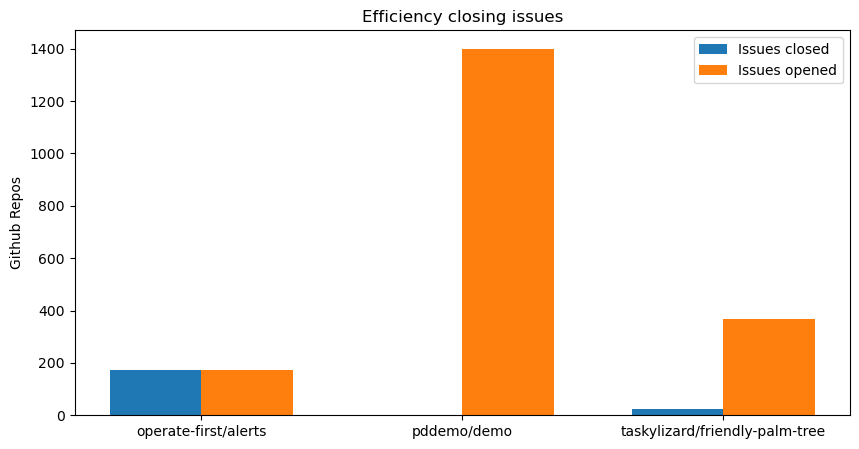

In [54]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(len(repos))  # the label locations
width = 0.35  # the width of the bars
plt.rcParams["figure.figsize"] = (10,5)

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, issues_closed, width, label='Issues closed')
rects2 = ax.bar(x + width/2, issues_open, width, label='Issues opened')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Github Repos')
ax.set_title('Efficiency closing issues')
ax.set_xticks(x, repos)
ax.legend()

plt.show()

### Popular ways of closing issues

In [6]:
spark.sql("""
SELECT REGEXP_EXTRACT(payload.issue.body, r'^([A-Za-z]+ [A-Za-z]+ [A-Za-z]+ [A-Za-z]+)') AS start, 
       COUNT(DISTINCT actor.login) AS authors, 
       ROUND(100*COUNT(payload.action=='closed')/COUNT(payload.action=='opened'),1)
         percentage_closed
FROM events
WHERE event_type='IssuesEvent'
GROUP BY 1
HAVING start != '' 
ORDER BY 2 DESC
LIMIT 20""").show(20, False)

+------------------------------+-------+-----------------+
|start                         |authors|percentage_closed|
+------------------------------+-------+-----------------+
|I would like to               |91     |100.0            |
|Is it possible to             |40     |100.0            |
|It would be nice              |39     |100.0            |
|I am trying to                |39     |100.0            |
|Is there a way                |24     |100.0            |
|I want to add                 |23     |100.0            |
|It would be great             |21     |100.0            |
|I think it would              |14     |100.0            |
|When I try to                 |13     |100.0            |
|This issue provides visibility|12     |100.0            |
|I was trying to               |12     |100.0            |
|Would it be possible          |12     |100.0            |
|I want to contribute          |10     |100.0            |
|Given an array of             |10     |100.0           